In [1]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.activations import *

from tensorflow.keras.regularizers import *

from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing import *

2023-04-04 13:51:57.554407: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-04 13:51:57.665599: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-04 13:51:57.691860: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (3.0.4) doesn't match a suppor

In [2]:
input_dir = './images/'
target_dir = './annotations/trimaps/'

img_paths=sorted([os.path.join(input_dir,f) 
                  for f in os.listdir(input_dir) 
                  if f.endswith('.jpg')])


label_paths=sorted([os.path.join(target_dir,f) 
                    for f in os.listdir(target_dir) 
                    if f.endswith('.png') and not f.startswith('.')])

In [3]:
img_siz = (160,160) 	# 모델에 입력되는 영상 크기
n_class = 3     		# 분할 레이블 (1:물체, 2:배경, 3:경계)
batch_siz = 32  		# 미니 배치 크기

In [4]:
class OxfordPets(keras.utils.Sequence):
    def __init__(self, batch_size,img_size,img_paths,label_paths):
        self.batch_size=batch_size
        self.img_size=img_size
        self.img_paths=img_paths
        self.label_paths=label_paths

    def __len__(self):
        return len(self.label_paths)//self.batch_size

    def __getitem__(self,idx):
        i = idx*self.batch_size
        batch_img_paths = self.img_paths[i:i+self.batch_size]
        batch_label_paths = self.label_paths[i:i+self.batch_size]
        
        
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_img_paths):
            img=load_img(path,target_size=self.img_size)
            x[j]=img
            
            
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_label_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img,2)
            y[j]-=1		# 부류 번호를 1,2,3에서 0,1,2로 변환
            
        return x,y

In [5]:
def U_Net(img_size,num_classes):
    inputs=Input(shape=img_size+(3,))

    # U-net의 다운 샘플링(축소 경로)
    x = Conv2D(32,3,strides=2,padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    previous_block_activation=x		# 지름길 연결을 위해

    
    for filters in [64,128,256]:
        x = Activation('relu')(x)
        x = SeparableConv2D(filters,3,padding='same')(x)
        x = BatchNormalization()(x)
        
        x = Activation('relu')(x)
        x = SeparableConv2D(filters,3,padding='same')(x)
        x = BatchNormalization()(x)
        
        x = MaxPooling2D(3,strides=2,padding='same')(x)
        
        residual = Conv2D(filters,1,strides=2,padding='same')(previous_block_activation)
        
        x=add([x,residual])	# 지름길 연결  
        
        previous_block_activation=x	# 지름길 연결을 위해

    # U-net의 업 샘플링(확대 경로)
    for filters in [256, 128, 64, 32]:
        x = Activation('relu')(x)
        x = Conv2DTranspose(filters,3,padding='same')(x)
        x = BatchNormalization()(x)
        
        x = Activation('relu')(x)
        x = Conv2DTranspose(filters,3,padding='same')(x)
        x = BatchNormalization()(x)
        
        x = UpSampling2D(2)(x)
        
        residual = UpSampling2D(2)(previous_block_activation)
        
        residual = Conv2D(filters,1,padding='same')(residual)
        
        x = add([x,residual])	# 지름길 연결
        
        previous_block_activation=x	# 지름길 연결을 위해

    outputs = Conv2D(num_classes,3,activation='softmax',padding='same')(x)
    
    model = Model(inputs, outputs)	# 모델 생성
    
    return model

In [6]:
model = U_Net(img_siz, n_class)		# 모델 생성
model.summary()

2023-04-04 13:51:59.451887: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-04 13:51:59.971263: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22292 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:19:00.0, compute capability: 8.6


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 80, 80, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 80, 80, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [7]:
random.Random(1).shuffle(img_paths)
random.Random(1).shuffle(label_paths)

test_samples = int(len(img_paths) * 0.1)	# 10%를 테스트 집합으로 사용
train_img_paths = img_paths[:-test_samples]
train_label_paths = label_paths[:-test_samples]
test_img_paths = img_paths[-test_samples:]
test_label_paths = label_paths[-test_samples:]

train_gen = OxfordPets(batch_siz,img_siz,train_img_paths,train_label_paths) # 훈련 집합
test_gen = OxfordPets(batch_siz,img_siz,test_img_paths,test_label_paths) # 검증 집합

In [8]:
import wandb

wandb.init(project="Segmentation_Oxford_pets", entity="hcim", name='U-Net')

from tensorflow.keras import callbacks
class WandbCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        wandb.log(logs)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: chan4im (hcim). Use `wandb login --relogin` to force relogin


In [9]:
# optimizer 설정
learning_rate = 1e-4
optimizer = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)

In [10]:
# 학습결과 자동저장
cb=[ModelCheckpoint('oxford_seg.h5',save_best_only=True)]



# learning rate 스케줄링
# 15 epoch마다 exp(-0.1)씩 learning_rate 감소
def lr_scheduler(epoch):
    if epoch < 15:
        return learning_rate
    else:
        return learning_rate * tf.math.exp(-0.1)

lr_callback = LearningRateScheduler(lr_scheduler)

callbacks = [[cb, lr_callback, WandbCallback()]]

In [11]:
available_cores = os.cpu_count()
available_cores

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
Exception in thread SystemMonitor:
Traceback (most recent call last):
  File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.8/dist-packages/wandb/sdk/internal/system/system_monitor.py", line 118, in _start
    asset.start()
  File "/usr/local/lib/python3.8/dist-packages/wandb/sdk/internal/system/assets/cpu.py", line 166, in start
    self.metrics_monitor.start()
  File "/usr/local/lib/python3.8/dist-packages/wandb/sdk/internal/system/assets/interfaces.py", line 168, in start
    logger.info(f"Started {self._process.name}")
AttributeError: 'NoneType' object has no attribute 'name'


20

In [12]:
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(train_gen, epochs=30, validation_data=test_gen, 
          use_multiprocessing=True,
          workers=18,
          callbacks=callbacks)

Epoch 1/30


2023-04-04 13:52:08.127976: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-04-04 13:52:09.513519: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


207/207 [==============================] - 25s 91ms/step - loss: 0.8933 - accuracy: 0.3065 - val_loss: 2.8517 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/30
207/207 [==============================] - 20s 87ms/step - loss: 0.6407 - accuracy: 0.3123 - val_loss: 2.6861 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04
Epoch 3/30
207/207 [==============================] - 20s 87ms/step - loss: 0.5833 - accuracy: 0.3122 - val_loss: 0.7564 - val_accuracy: 0.1504 - lr: 1.0000e-04
Epoch 4/30
207/207 [==============================] - 21s 89ms/step - loss: 0.5430 - accuracy: 0.3133 - val_loss: 0.5503 - val_accuracy: 0.2795 - lr: 1.0000e-04
Epoch 5/30
207/207 [==============================] - 21s 89ms/step - loss: 0.5134 - accuracy: 0.3133 - val_loss: 0.5466 - val_accuracy: 0.2868 - lr: 1.0000e-04
Epoch 6/30
207/207 [==============================] - 21s 89ms/step - loss: 0.4881 - accuracy: 0.3139 - val_loss: 0.5140 - val_accuracy: 0.3398 - lr: 1.0000e-04
Epoch 7/30
207/207 [=================

In [13]:
preds=model.predict(test_gen)	# 예측

23/23 [==============================] - 3s 95ms/step


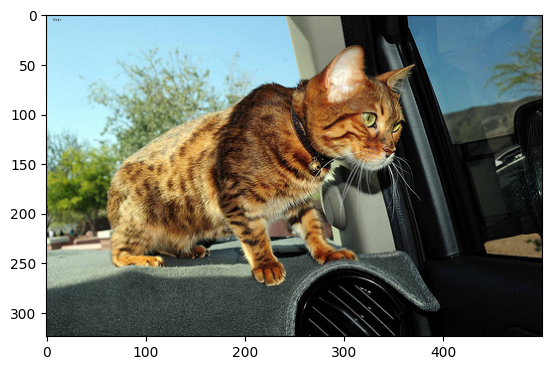

In [17]:
plt.imshow(plt.imread(test_img_paths[0]))      # 0번 영상 디스플레이

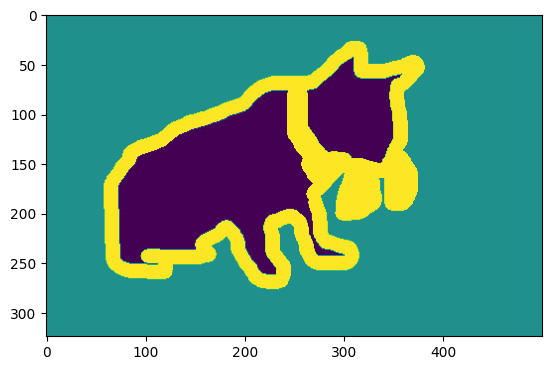

In [18]:
plt.imshow(plt.imread(test_label_paths[0])*64)

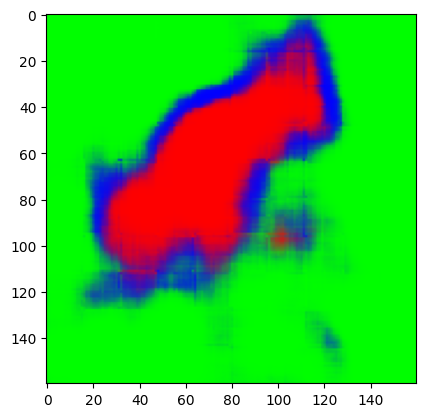

In [19]:
plt.imshow(preds[0]) # 0번 영상 예측 결과 디스플레이